In [ ]:
from helper import split_name
from read_data import pull_data, prepare_data, get_expert_projections
from modeling import split_data_random, create_baseline, tune_xgb, create_model, generate_prediction_intervals, compile_predictions, combine_projections
from data_viz import plot_actual_vs_pred_mlb, plot_resid_vs_pred_mlb, plot_resid_hist_mlb, plot_decile_calib
from clean_and_cluster import assign_position_group, finalize_predictions, split_batters_if_of, create_draft_pool, calculate_relative_value, determine_optimal_k, segment_players
from config import BAT_POS_OVERRIDES, AGG_YEARS, SCORING_RULES, batting_stat_cols, pitching_stat_cols, batting_agg_cols, pitching_agg_cols, param_space, POS_DAMPENING_MAP
from xgboost import plot_importance
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

FORMAT = "DK" # <- Indicator for scoring format ("UD" for Underdog, "DK" for DraftKings, etc.)
START_YEAR = 2005 # <- Beginning season for data pull
END_YEAR = 2025 # <- Ending season for data pull, final model will predict following season
MODEL_WEIGHT = 0.67
PROJECTION_WEIGHT = 1 - MODEL_WEIGHT
ROSTER_SIZE = 20
LEAGUE_SIZE = 12
BONUS_PLAYER_POOL_MULT = 1.15
PITCHER_SPLIT = 0.34
BATTER_SPLIT_IF = 0.33
BATTER_SPLIT_OF = 0.33
SEED = 320212

# URL of the FantasyPros projections page
batting_url = "https://www.fantasypros.com/mlb/projections/hitters.php"
pitching_url = "https://www.fantasypros.com/mlb/projections/pitchers.php"

In [16]:
player_pool = (ROSTER_SIZE * LEAGUE_SIZE) * BONUS_PLAYER_POOL_MULT
pitcher_pool = round(player_pool * PITCHER_SPLIT, 0)
batter_pool_if = round(player_pool * BATTER_SPLIT_IF, 0)
batter_pool_of = round(player_pool * BATTER_SPLIT_OF, 0)

In [17]:
# Pull data for batters & pitchers
batting_df, pitching_df = pull_data(
    start_year=START_YEAR,
    end_year=END_YEAR,
    agg_years=AGG_YEARS,
    batting_stat_cols=batting_stat_cols,
    pitching_stat_cols=pitching_stat_cols,
    batting_agg_cols=batting_agg_cols,
    pitching_agg_cols=pitching_agg_cols,
    career_window_years=10, # NOTE: as of 2025, career aggregates can only reach back 10 years in a single pull - rule in pybaseball
    fmt=FORMAT
)

# Prepare data for modeling
batting_df, pitching_df, batting_pred, pitching_pred = prepare_data(
    batting_df,
    pitching_df,
    pred_season=END_YEAR,
)

Loaded existing UD data files.


In [18]:
# TODO: Fix up n_estimators documentation
# TODO: Create a feature_engineering.py file

# Pulling FantasyPros Projection Data

In [19]:
batting_projections, pitching_projections = get_expert_projections(
    batting_url=batting_url,
    pitching_url=pitching_url,
    fmt=FORMAT,
    scoring_rules=SCORING_RULES,
)

# Creating Batting Model

## Creating baseline batting predictions

In [20]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data_random(batting_df, random_state=SEED)

# Plotting data
model, y_pred = create_baseline(x_train.drop(columns=['IDfg']), x_val.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), 
                                            y_train, y_val, y_test)

# Compiling baseline predictions
batting_comp = compile_predictions(batting_df, x_test, y_test, y_pred)
display(batting_comp.head(10))

[Test] RMSE: 311.373 | MAE: 251.303 | R^2: 0.480 | Spearman: 0.683


,Name,fantasy_points_future,predicted_fantasy_points,prediction_diff,absolute_diff,Season,Age,fantasy_points
379,Mookie Betts,1561.0,1623.048706,62.048706,62.048706,2016,23,1737.0
214,Albert Pujols,1808.0,1600.309814,-207.690186,207.690186,2009,29,1981.0
776,Shohei Ohtani,2143.0,1564.227783,-578.772217,578.772217,2023,28,1635.0
209,Michael Young,1487.0,1525.567627,38.567627,38.567627,2005,28,1589.0
285,Vladimir Guerrero Jr.,1341.0,1475.606934,134.606934,134.606934,2022,23,1452.0
537,Josh Donaldson,1161.0,1472.140259,311.140259,311.140259,2016,30,1696.0
654,Jimmy Rollins,1678.0,1469.280762,-208.719238,208.719238,2005,26,1496.0
297,Jorge Cantu,766.0,1452.373901,686.373901,686.373901,2005,23,1293.0
531,Brian Roberts,480.0,1432.501343,952.501343,952.501343,2009,31,1548.0
253,Jose Altuve,1236.0,1430.112671,194.112671,194.112671,2017,27,1632.0


# Building Batting Model

# Batting Predictions

In [21]:
# Tune model
best_params, best_iter = tune_xgb(
    X_train=x_train,
    X_val=x_val,
    y_train=y_train,
    y_val=y_val,
    space=param_space,
    model_objective="reg:squarederror",
    metric="rmse",     
    evals=50,
    random_state=SEED,
    id_cols=["IDfg"],
)

# Generating prediction intervals via bootstrap-resampled models
batting_intervals = generate_prediction_intervals(
    X_train=x_train,
    y_train=y_train,
    X_pred=batting_pred.drop(columns=['fantasy_points_future']),
    base_params=best_params,
    model_objective="reg:squarederror",
    metric="rmse",
    n_bootstrap=40,
    random_state=SEED,
    id_cols=['IDfg', 'Name'],
    n_estimators=2000,
    early_stopping_rounds=100,
)

100%|██████████| 50/50 [05:14<00:00,  6.30s/trial, best loss: 299.75574771697325]
[Early stopping summary] mean=498, min=144, max=1231
Best Parameters: {'learning_rate': 0.027239758806155288, 'max_leaves': 32, 'grow_policy': 'lossguide', 'subsample': 0.9131306701960453, 'colsample_bytree': 0.6577064785747807, 'min_child_weight': 1.2247530013101664, 'reg_lambda': 5.32728286649892, 'reg_alpha': 0.021391385617668558, 'gamma': 0.0011610220507309468}
[Best trial @ val] optimized=rmse | RMSE=299.756 | MAE=235.235 | R^2=0.528 | SPEAR=0.710 


Bootstrapping prediction intervals: 100%|██████████| 40/40 [02:21<00:00,  3.55s/it]


In [22]:
# Create final model
batting_model, y_pred = create_model(
    X_train=x_train,
    X_val=x_val,
    X_test=x_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    final_params=best_params,
    n_estimators=best_iter,
    model_objective="reg:squarederror",
    metric="rmse",
    random_state=SEED,
    id_cols=["IDfg"],        
)

[Test] RMSE: 307.667 | MAE: 247.885 | R^2: 0.493 | SPEAR: 0.691


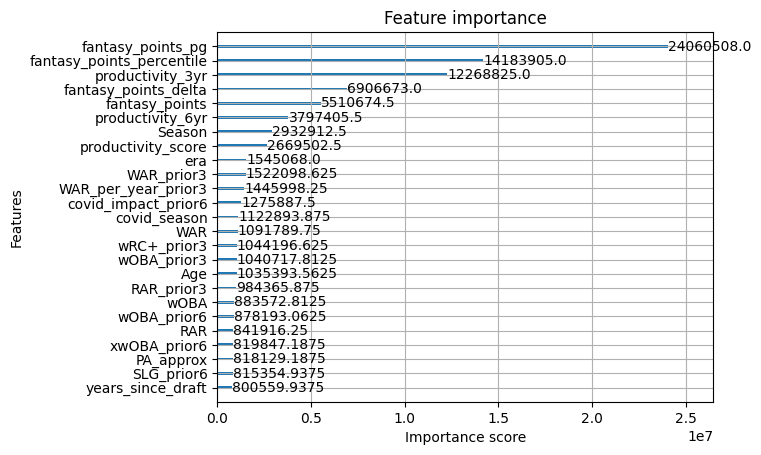

In [23]:
# Plot feature importance using XGBoost's built-in method
plot_importance(batting_model, importance_type="gain", max_num_features=25)
plt.show()

In [24]:
batting_results = compile_predictions(batting_df, x_test, y_test, y_pred)
display(batting_results.head(10))

,Name,fantasy_points_future,predicted_fantasy_points,prediction_diff,absolute_diff,Season,Age,fantasy_points
214,Albert Pujols,1808.0,1635.812256,-172.187744,172.187744,2009,29,1981.0
776,Shohei Ohtani,2143.0,1546.114990,-596.885010,596.885010,2023,28,1635.0
379,Mookie Betts,1561.0,1522.816650,-38.183350,38.183350,2016,23,1737.0
285,Vladimir Guerrero Jr.,1341.0,1508.232056,167.232056,167.232056,2022,23,1452.0
654,Jimmy Rollins,1678.0,1457.154785,-220.845215,220.845215,2005,26,1496.0
318,Matt Holliday,1557.0,1454.441040,-102.558960,102.558960,2009,29,1554.0
209,Michael Young,1487.0,1448.413818,-38.586182,38.586182,2005,28,1589.0
731,Jackson Merrill,932.0,1445.226196,513.226196,513.226196,2024,21,1265.0
253,Jose Altuve,1236.0,1442.204956,206.204956,206.204956,2017,27,1632.0
297,Jorge Cantu,766.0,1417.625977,651.625977,651.625977,2005,23,1293.0


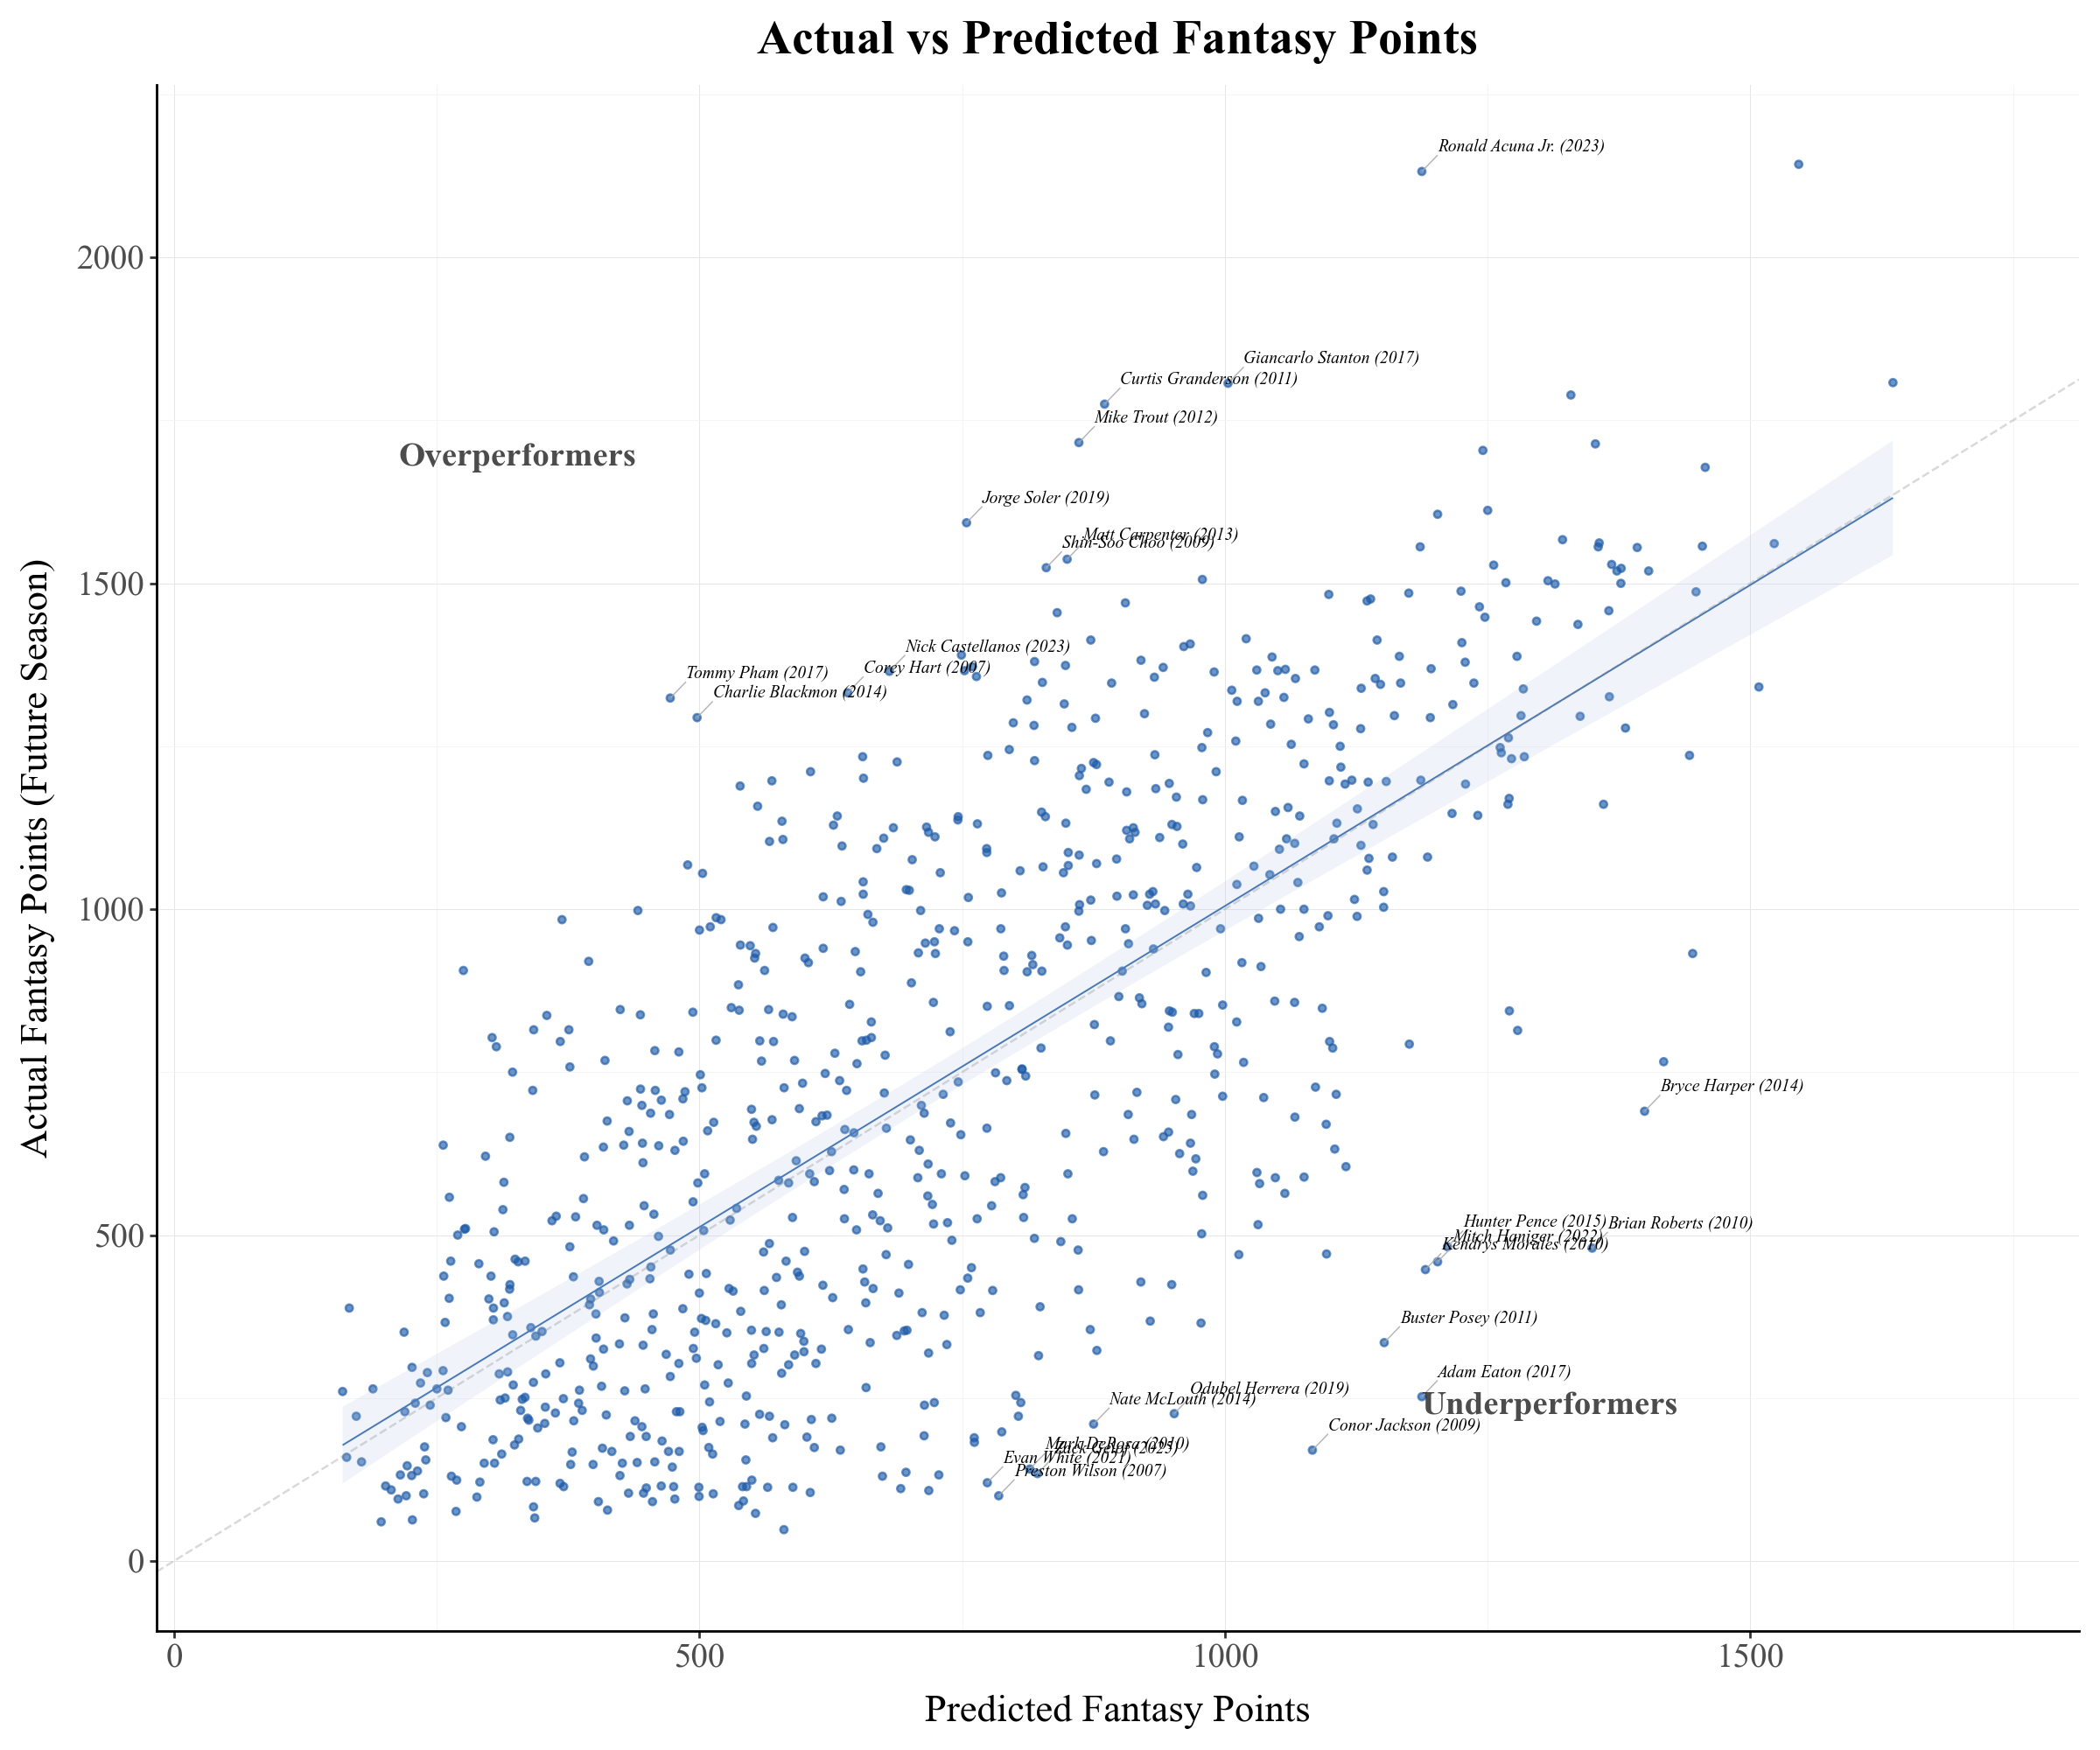

In [25]:
p1 = plot_actual_vs_pred_mlb(
    batting_results,
    top_n=25,
    x_offset=15,
    y_offset=25,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p1.show()

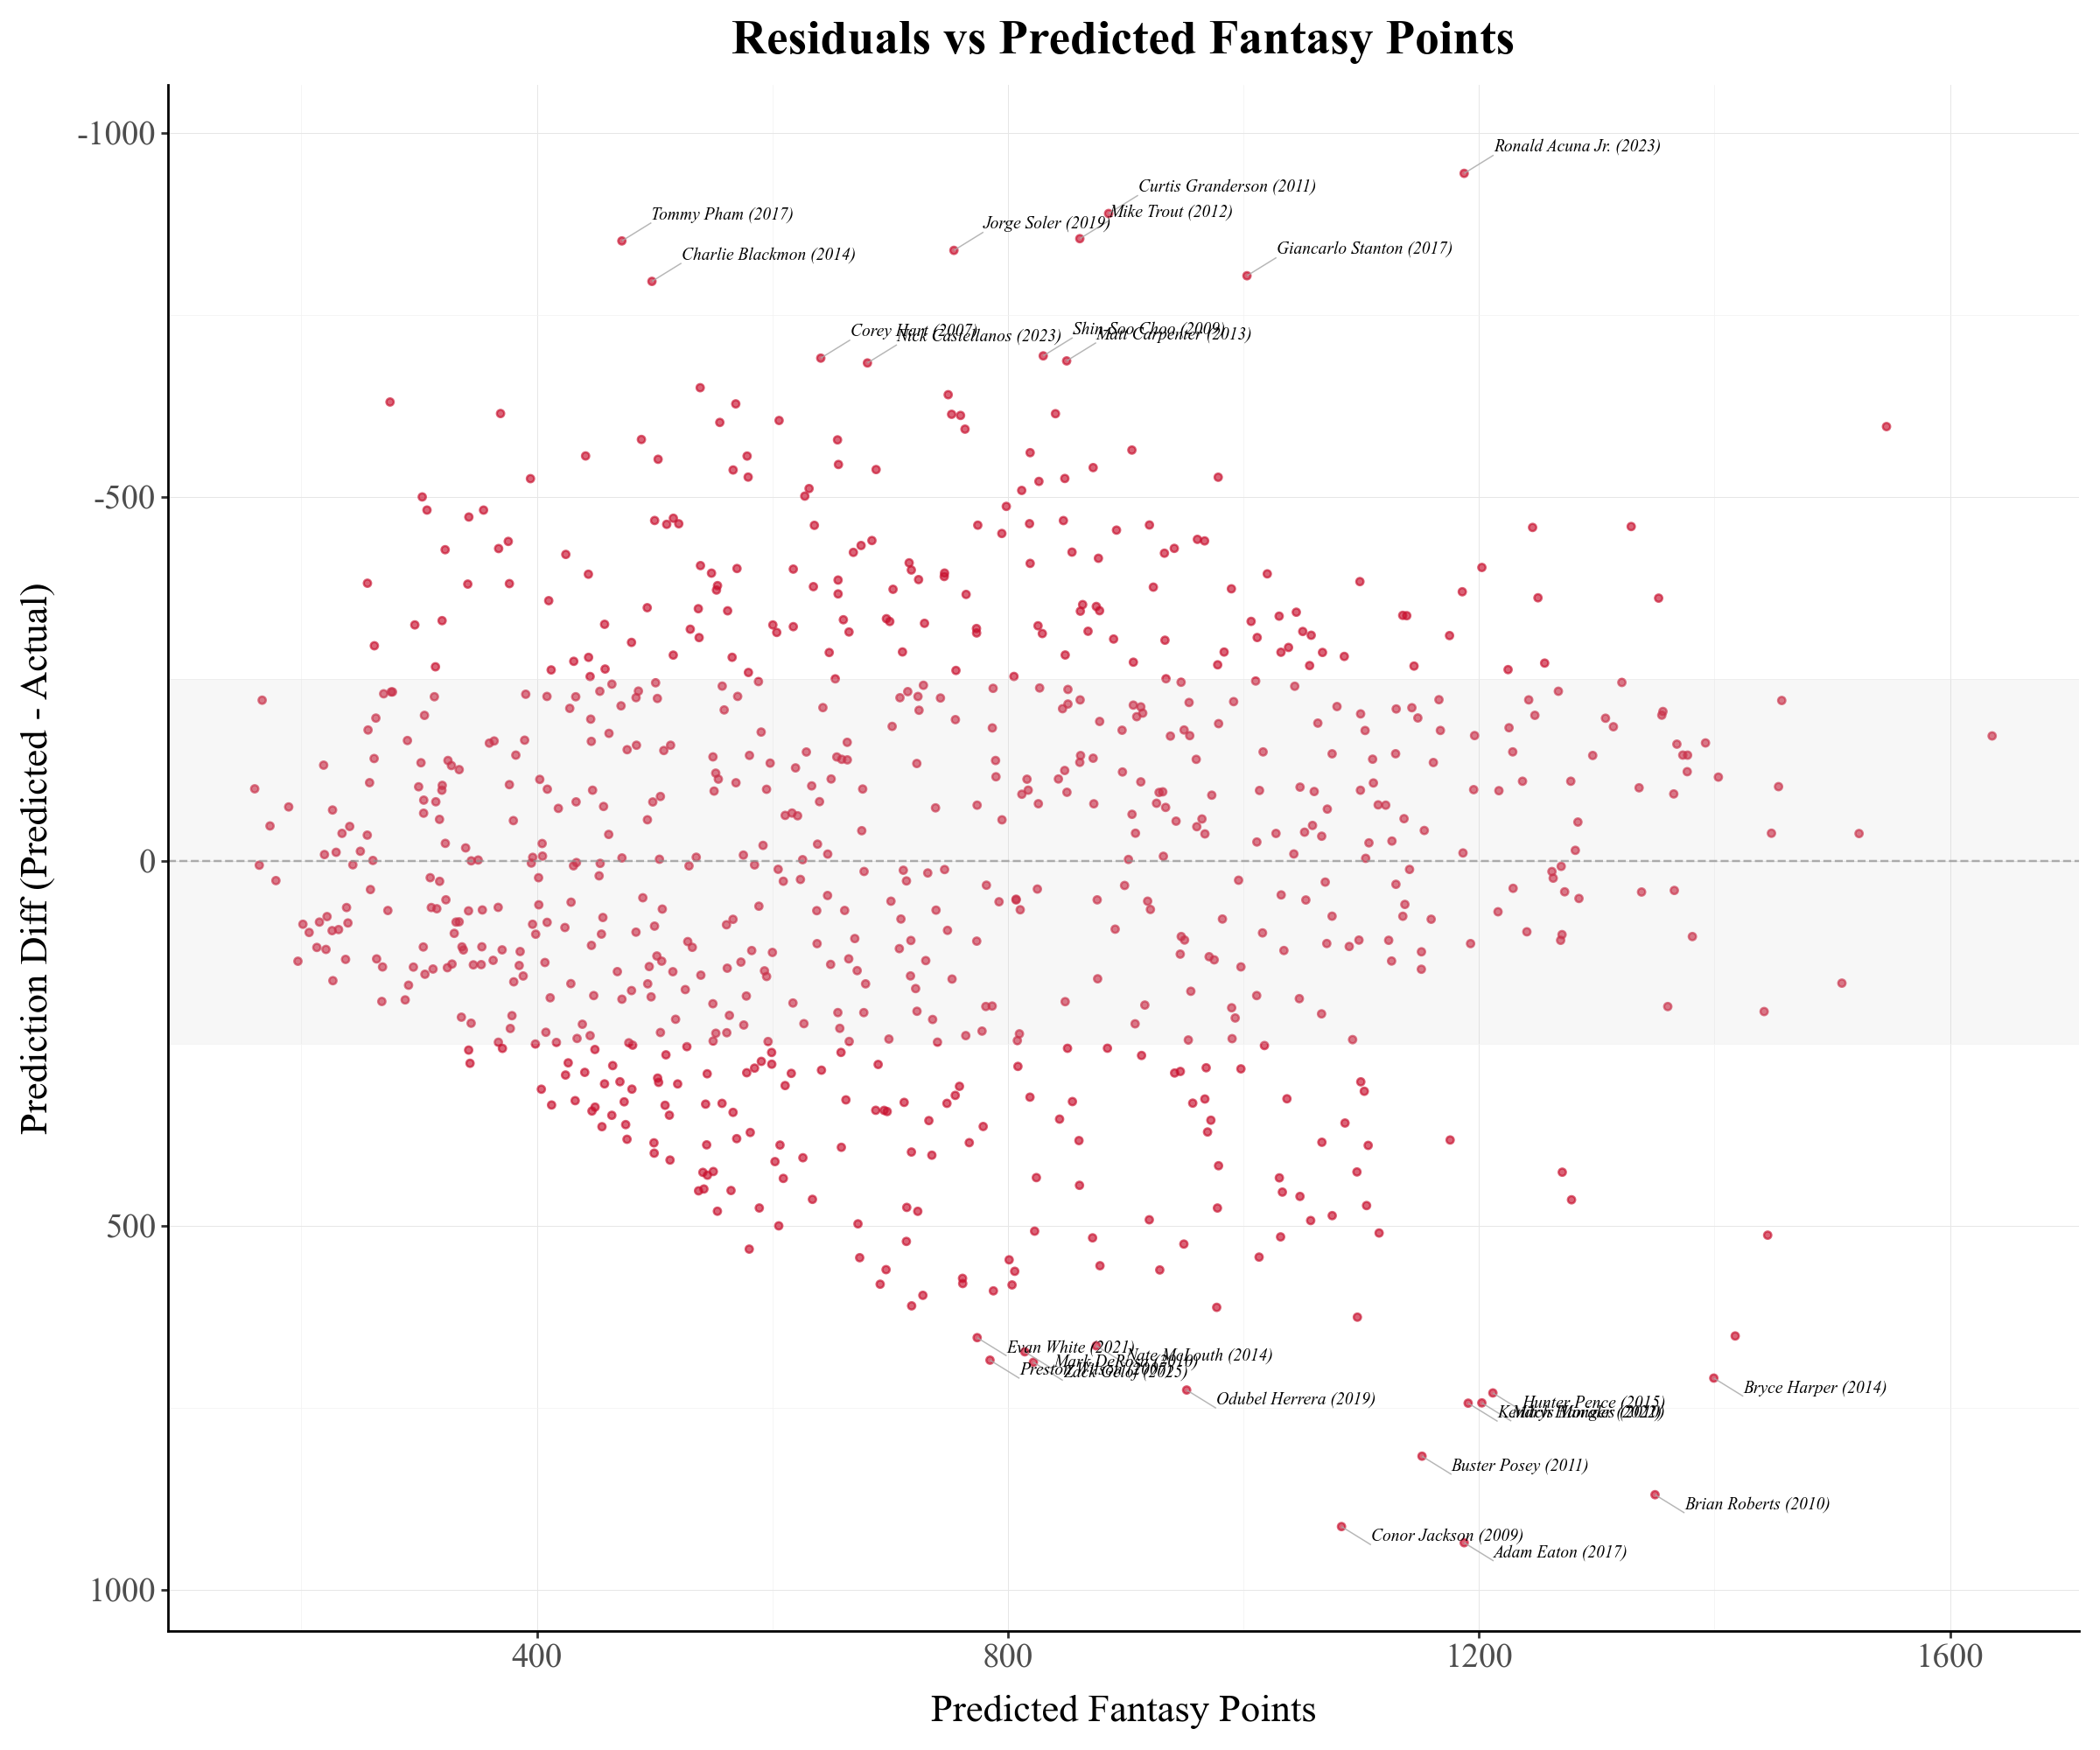

In [26]:
p2 = plot_resid_vs_pred_mlb(
    batting_results,
    band=250,
    top_n=25,
    reverse_y=True,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p2.show()

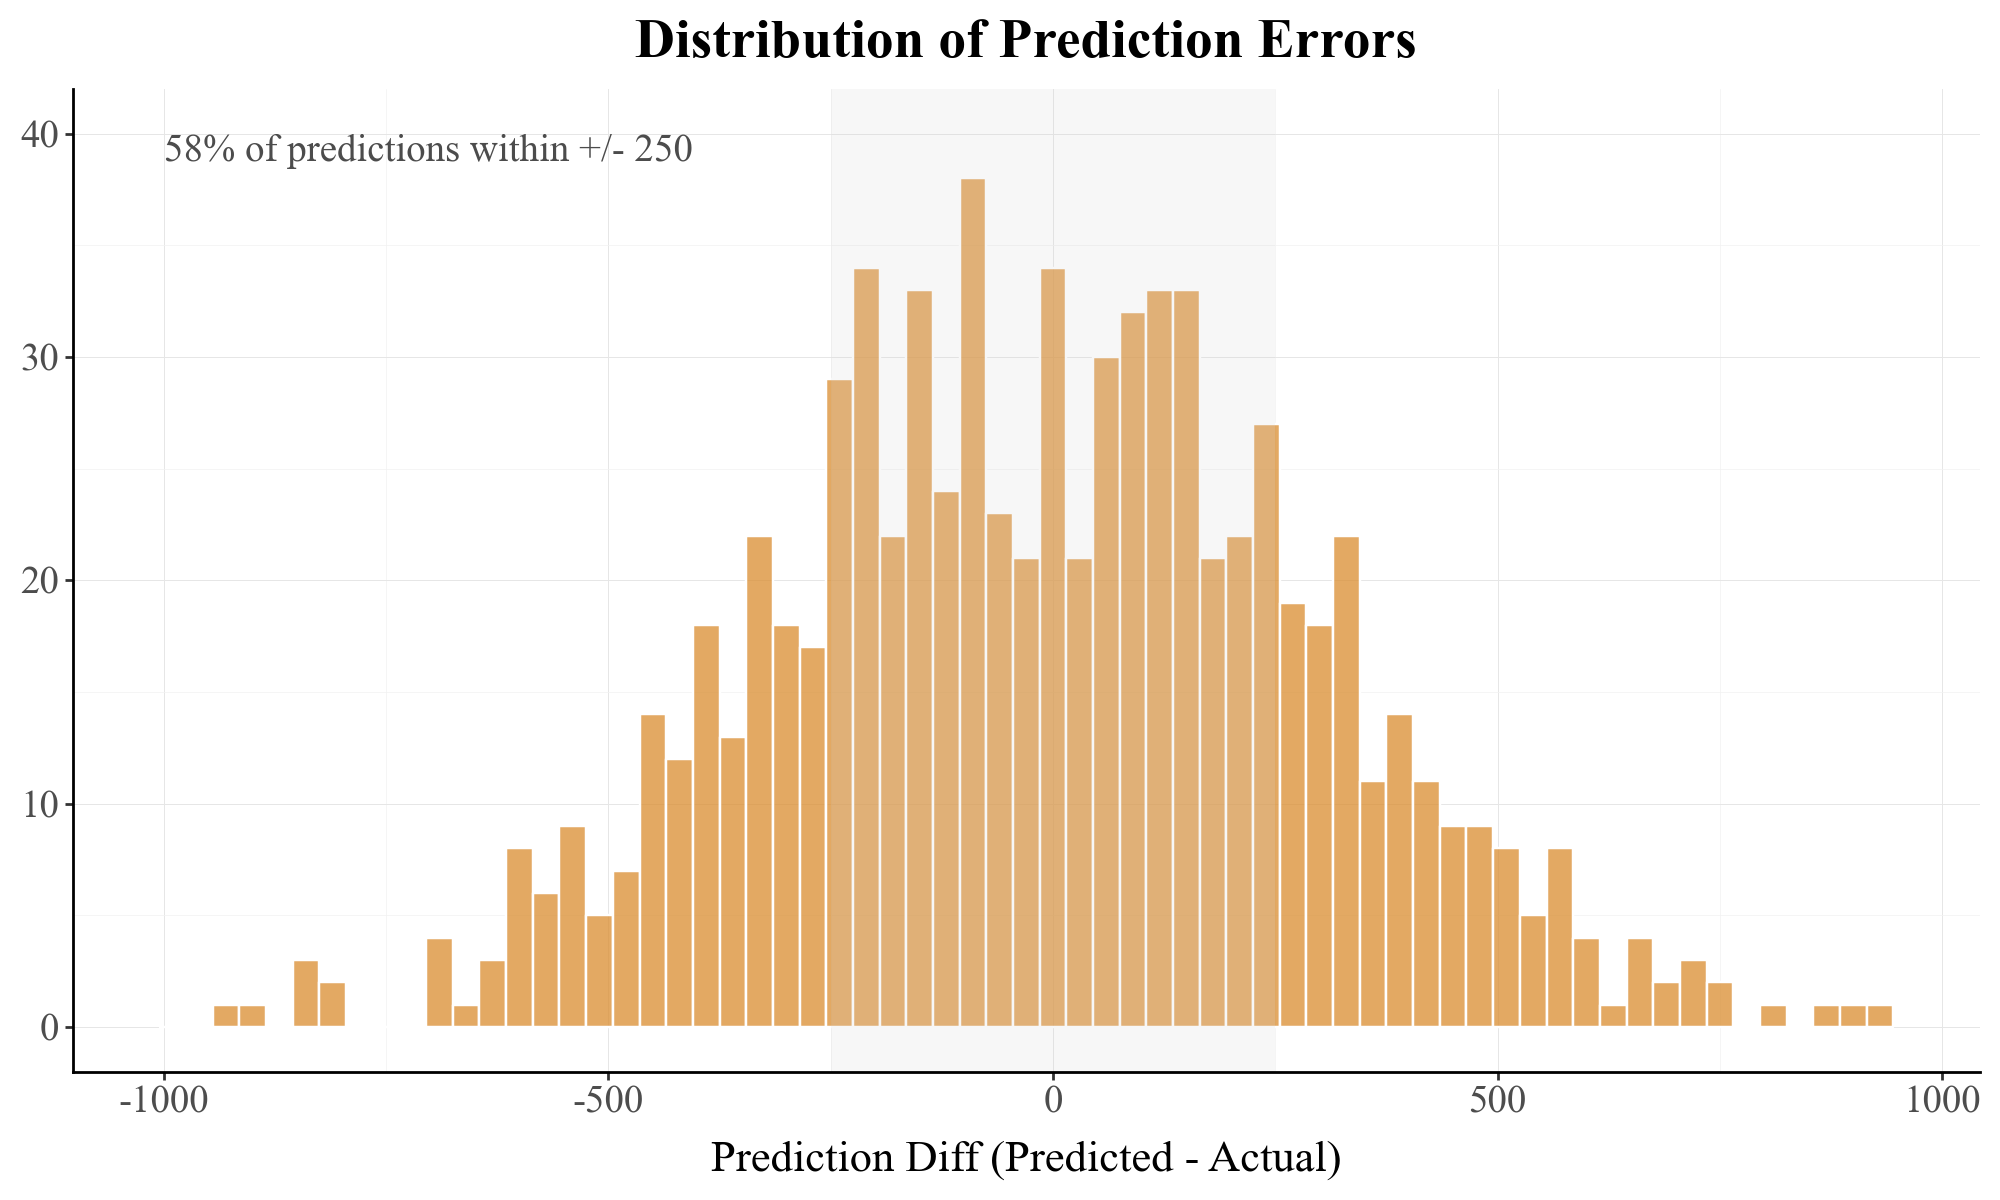

In [ ]:
p3 = plot_resid_hist_mlb(
    batting_results,
    band=250,
    binwidth=25,
    x_annotate=-1000,    # custom annotation position
    y_annotate=40,      # custom annotation position
)
p3.show()

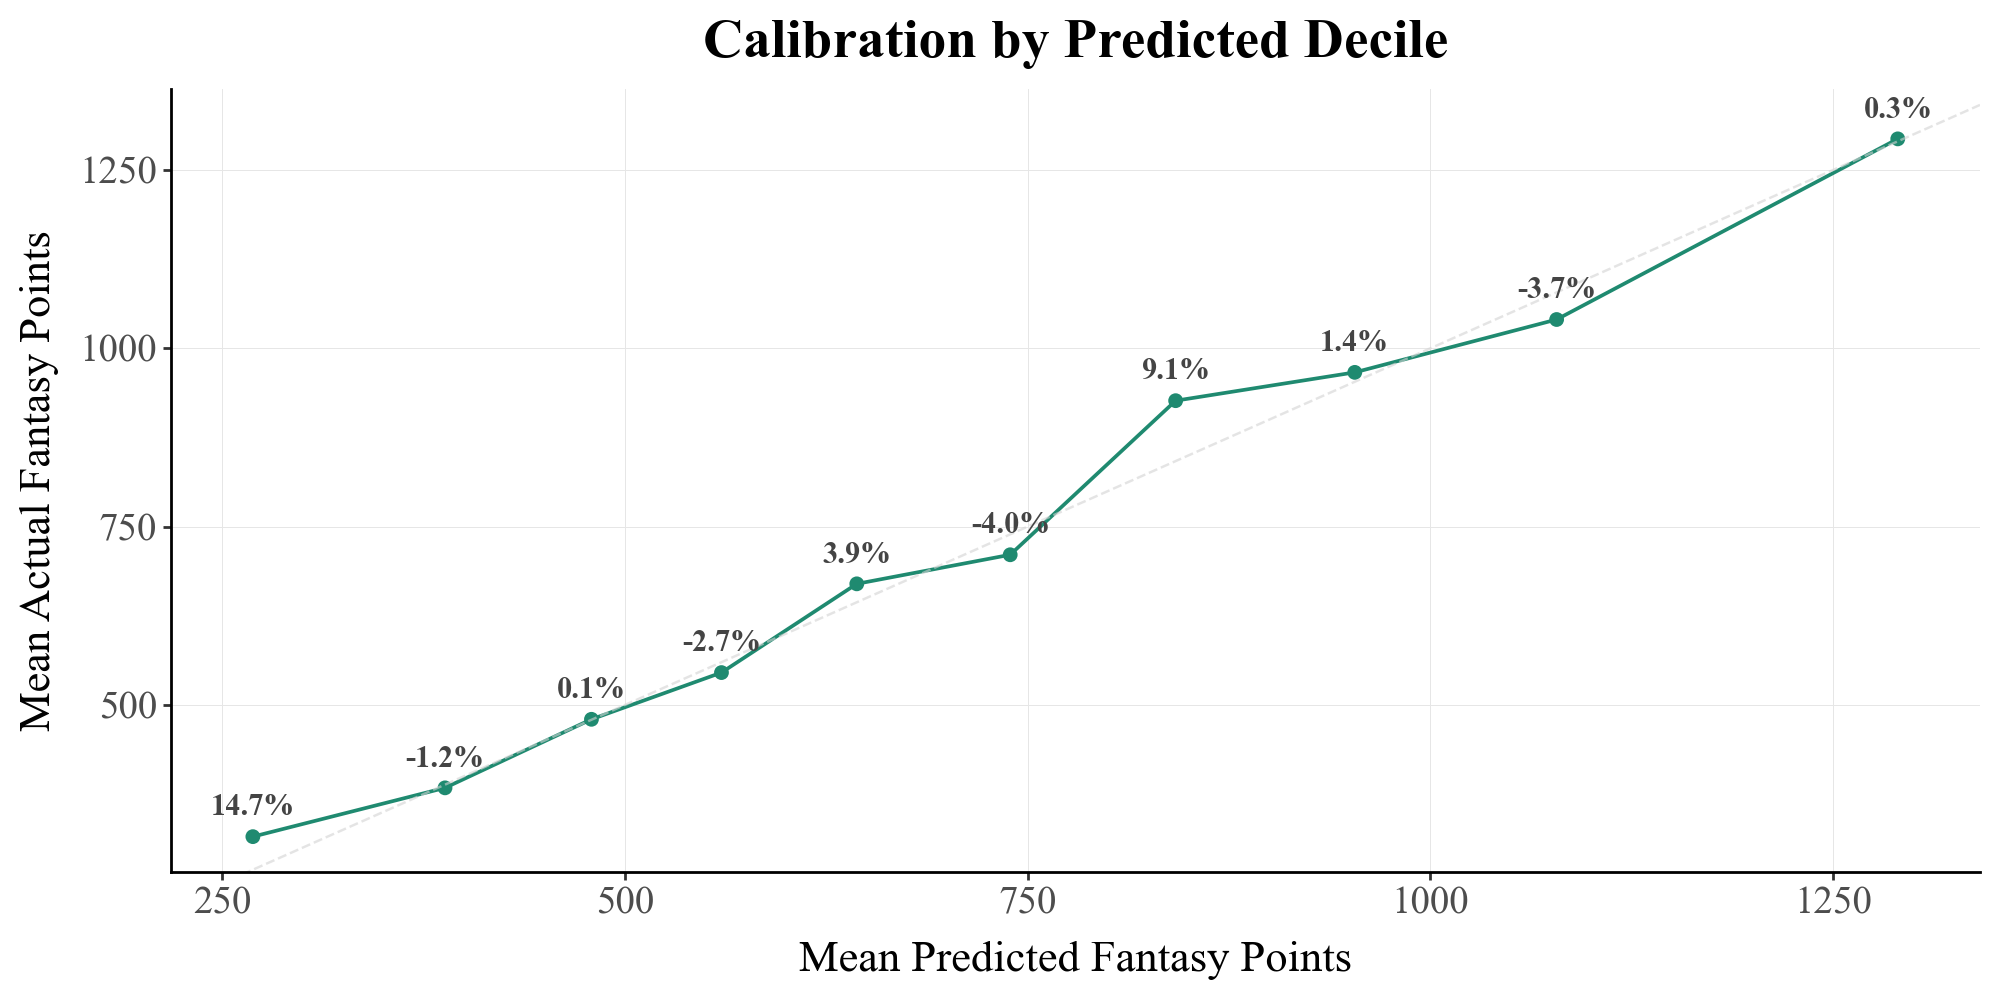

In [28]:
p4 = plot_decile_calib(batting_results)
p4.show()

# Creating Pitching Model

# Creating baseline pitching predictions

In [29]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data_random(pitching_df, random_state=SEED)

# Plotting data
model, y_pred = create_baseline(x_train.drop(columns=['IDfg']), x_val.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), 
                                            y_train, y_val, y_test)

[Test] RMSE: 195.362 | MAE: 149.213 | R^2: 0.545 | Spearman: 0.640


In [30]:
pitching_comp = compile_predictions(pitching_df, x_test, y_test, y_pred)
display(pitching_comp.head(10))

,Name,fantasy_points_future,predicted_fantasy_points,prediction_diff,absolute_diff,Season,Age,fantasy_points
101,Jake Peavy,902.6,1123.958984,221.358984,221.358984,2007,26,1295.3
265,David Price,1153.0,1090.915283,-62.084717,62.084717,2015,29,1245.3
218,CC Sabathia,1369.0,1055.544067,-313.455933,313.455933,2007,26,1187.0
569,Clayton Kershaw,1371.3,1042.040161,-329.259839,329.259839,2010,22,1115.3
760,Jake Peavy,1030.3,1011.022827,-19.277173,19.277173,2005,24,1127.0
500,James Shields,1055.3,974.104919,-81.195081,81.195081,2014,32,1048.0
330,Felix Hernandez,685.3,961.880005,276.580005,276.580005,2015,29,1029.6
320,Gio Gonzalez,997.6,941.435303,-56.164697,56.164697,2012,26,1131.3
170,Justin Verlander,1482.0,940.067810,-541.932190,541.932190,2018,35,1412.0
732,Matt Garza,487.6,935.280884,447.680884,447.680884,2011,27,1016.0


# Pitching Predictions

In [31]:
# Tune model
best_params, best_iter = tune_xgb(
    X_train=x_train,
    X_val=x_val,
    y_train=y_train,
    y_val=y_val,
    space=param_space,
    model_objective="reg:squarederror",
    metric="rmse",     
    evals=50,
    random_state=SEED,
    id_cols=["IDfg"],
)

# Generating prediction intervals via bootstrap-resampled models
pitching_intervals = generate_prediction_intervals(
    X_train=x_train,
    y_train=y_train,
    X_pred=pitching_pred.drop(columns=['fantasy_points_future']),
    base_params=best_params,
    model_objective="reg:squarederror",
    metric="rmse",
    n_bootstrap=40,
    random_state=SEED,
    id_cols=['IDfg', 'Name'],
    n_estimators=2000,
    early_stopping_rounds=100,
)

100%|██████████| 50/50 [03:17<00:00,  3.96s/trial, best loss: 197.5935154867243] 
[Early stopping summary] mean=314, min=69, max=838
Best Parameters: {'learning_rate': 0.04460256327687769, 'max_leaves': 10, 'grow_policy': 'lossguide', 'subsample': 0.9370563986130358, 'colsample_bytree': 0.7887049030004911, 'min_child_weight': 5.315013280514196, 'reg_lambda': 0.001097622652182091, 'reg_alpha': 0.037515906610367106, 'gamma': 0.011845654739857828}
[Best trial @ val] optimized=rmse | RMSE=197.594 | MAE=146.762 | R^2=0.518 | SPEAR=0.642 


Bootstrapping prediction intervals: 100%|██████████| 40/40 [01:00<00:00,  1.52s/it]


In [32]:
# Create final model
pitching_model, y_pred = create_model(
    X_train=x_train,
    X_val=x_val,
    X_test=x_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    final_params=best_params,
    n_estimators=best_iter,
    model_objective="reg:squarederror",
    metric="rmse",
    random_state=SEED,
    id_cols=["IDfg"],          
)

[Test] RMSE: 190.787 | MAE: 145.610 | R^2: 0.566 | SPEAR: 0.655


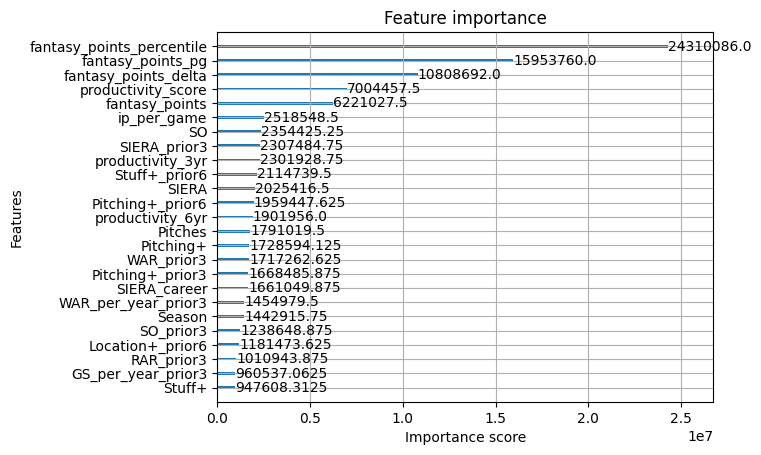

In [33]:
# Plot feature importance using XGBoost's built-in method
plot_importance(pitching_model, importance_type="gain", max_num_features=25)
plt.show()

In [34]:
pitching_results = compile_predictions(pitching_df, x_test, y_test, y_pred)
display(pitching_results.head(10))

,Name,fantasy_points_future,predicted_fantasy_points,prediction_diff,absolute_diff,Season,Age,fantasy_points
218,CC Sabathia,1369.0,1070.295898,-298.704102,298.704102,2007,26,1187.0
101,Jake Peavy,902.6,1056.973755,154.373755,154.373755,2007,26,1295.3
170,Justin Verlander,1482.0,1032.186157,-449.813843,449.813843,2018,35,1412.0
265,David Price,1153.0,1030.708252,-122.291748,122.291748,2015,29,1245.3
213,Justin Verlander,1119.0,1029.595093,-89.404907,89.404907,2016,33,1292.6
50,Aaron Nola,957.6,1021.346252,63.746252,63.746252,2022,29,1153.0
735,Roy Halladay,1271.6,1015.269897,-256.330103,256.330103,2010,33,1308.6
580,Carlos Zambrano,1109.0,984.381226,-124.618774,124.618774,2005,24,1102.3
569,Clayton Kershaw,1371.3,962.730164,-408.569836,408.569836,2010,22,1115.3
500,James Shields,1055.3,953.024475,-102.275525,102.275525,2014,32,1048.0


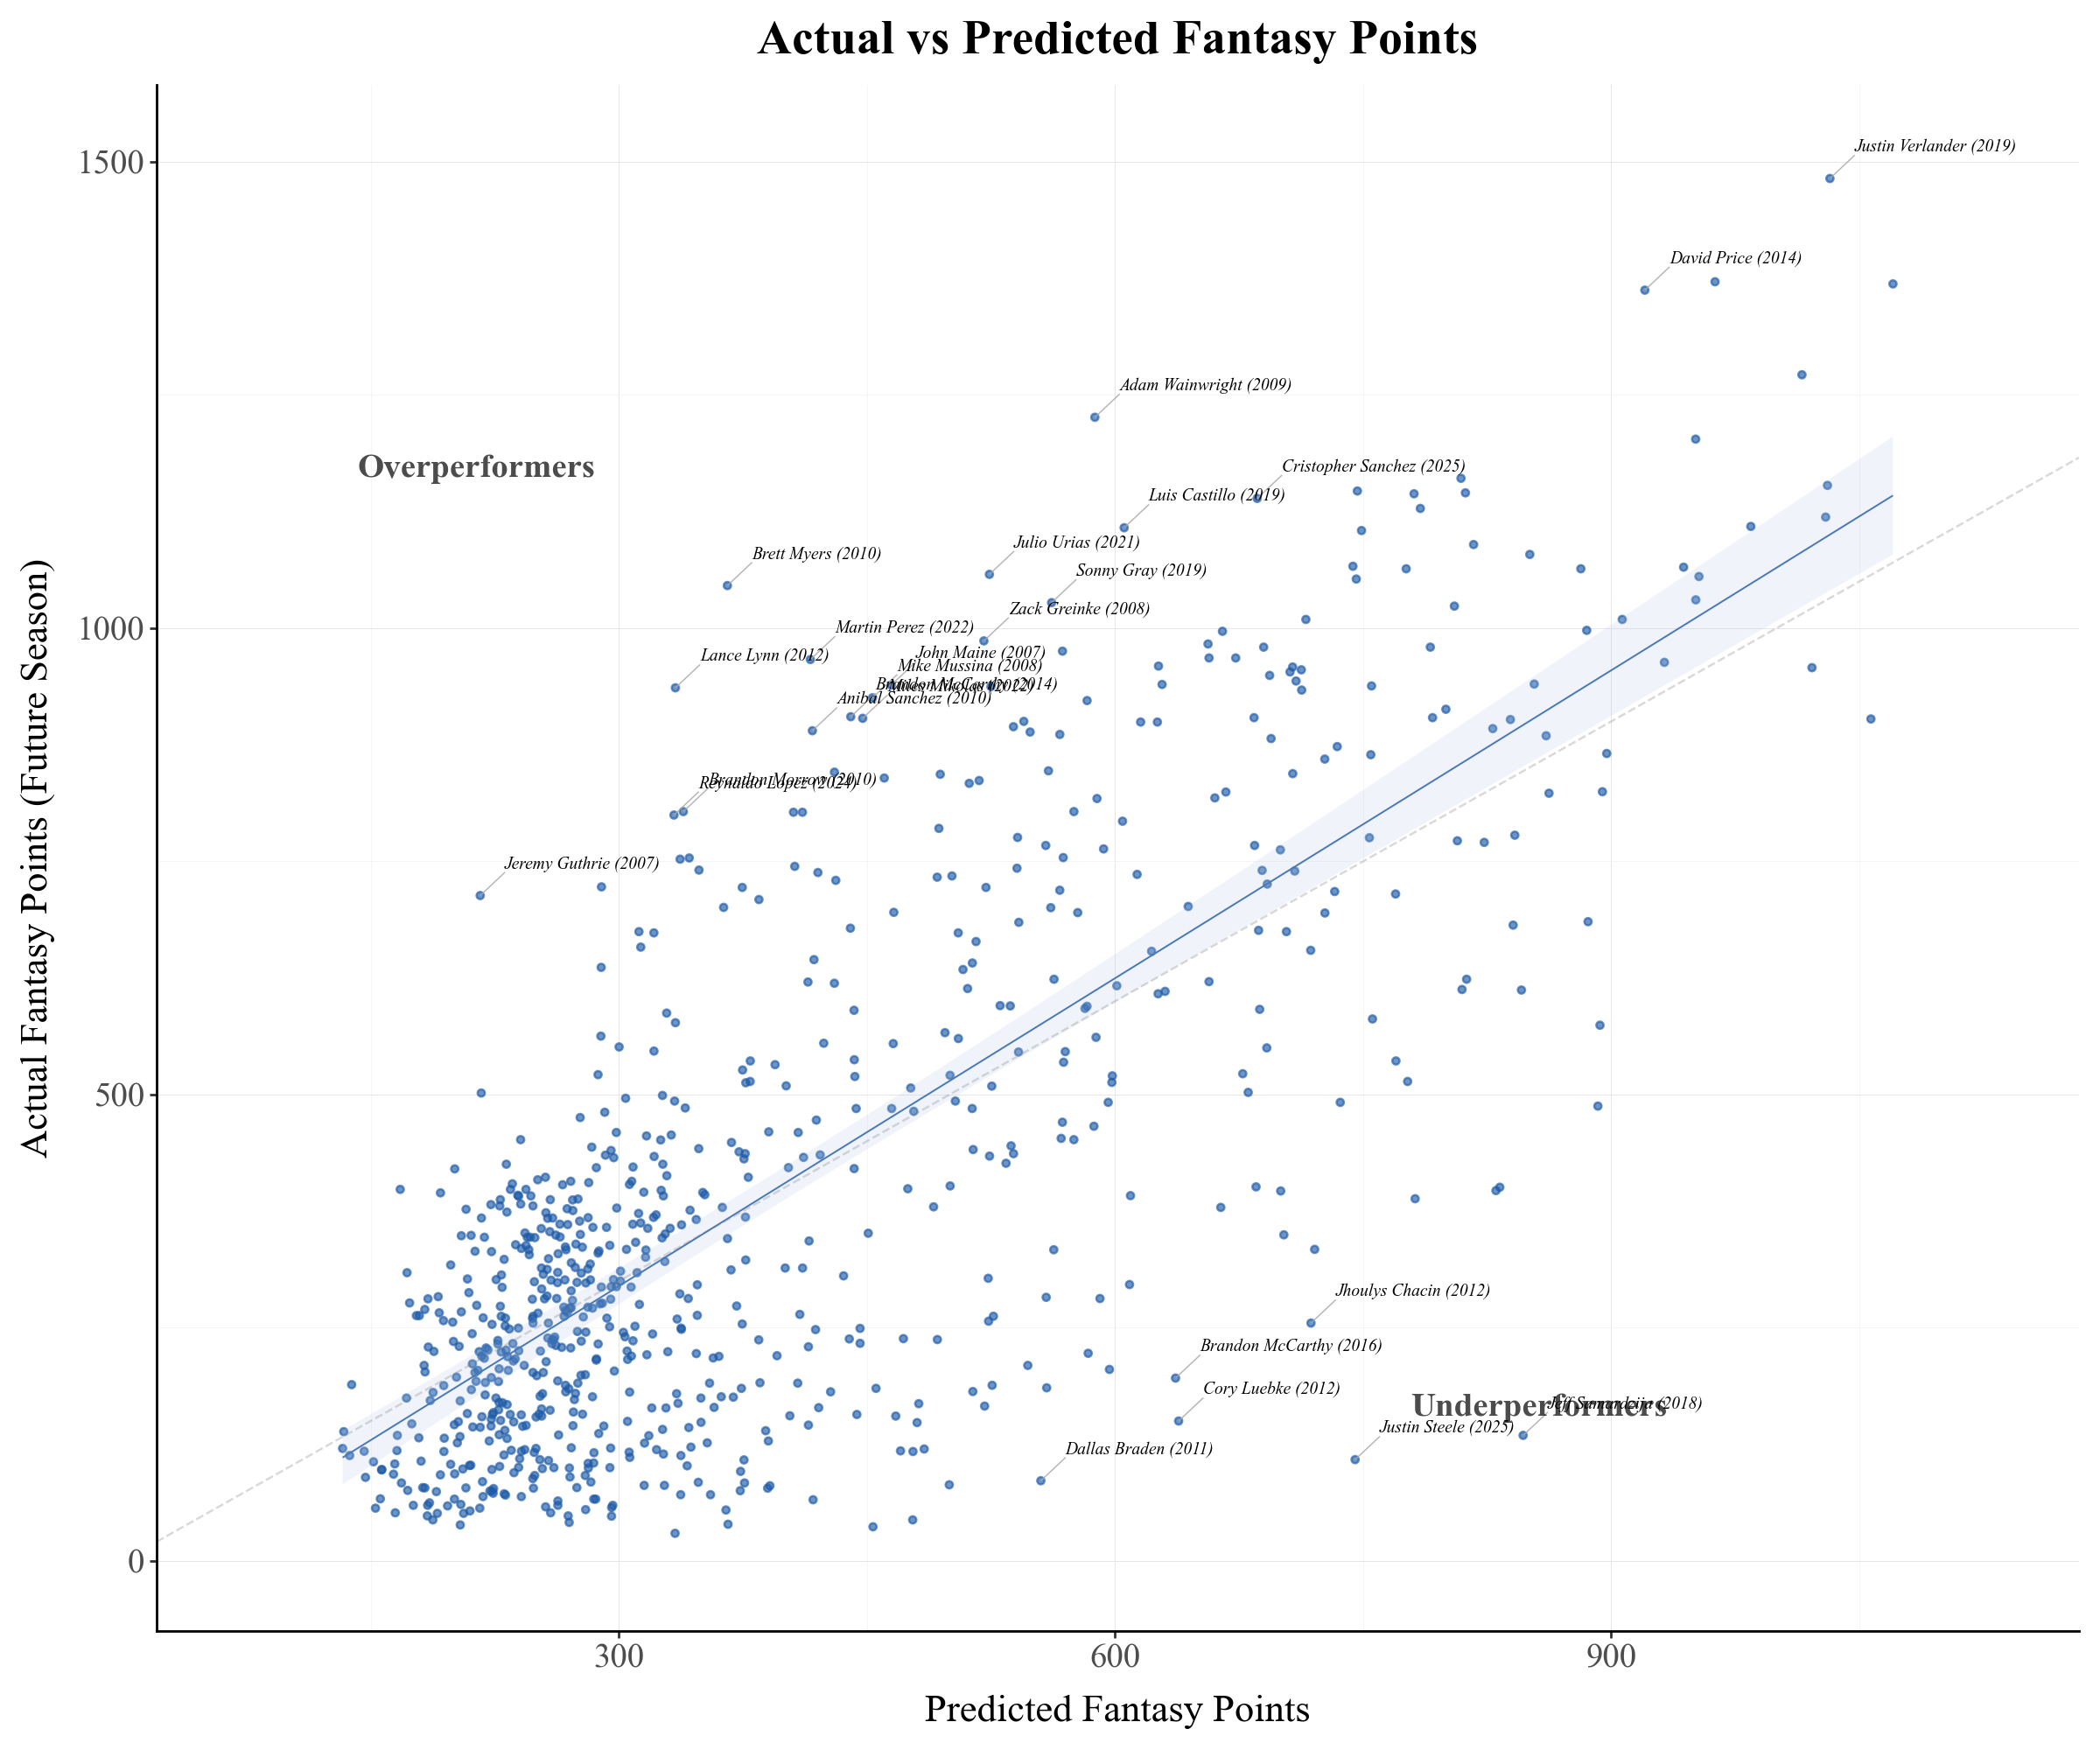

In [35]:
p1 = plot_actual_vs_pred_mlb(
    pitching_results,
    top_n=25,
    x_offset=15,
    y_offset=25,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p1.show()

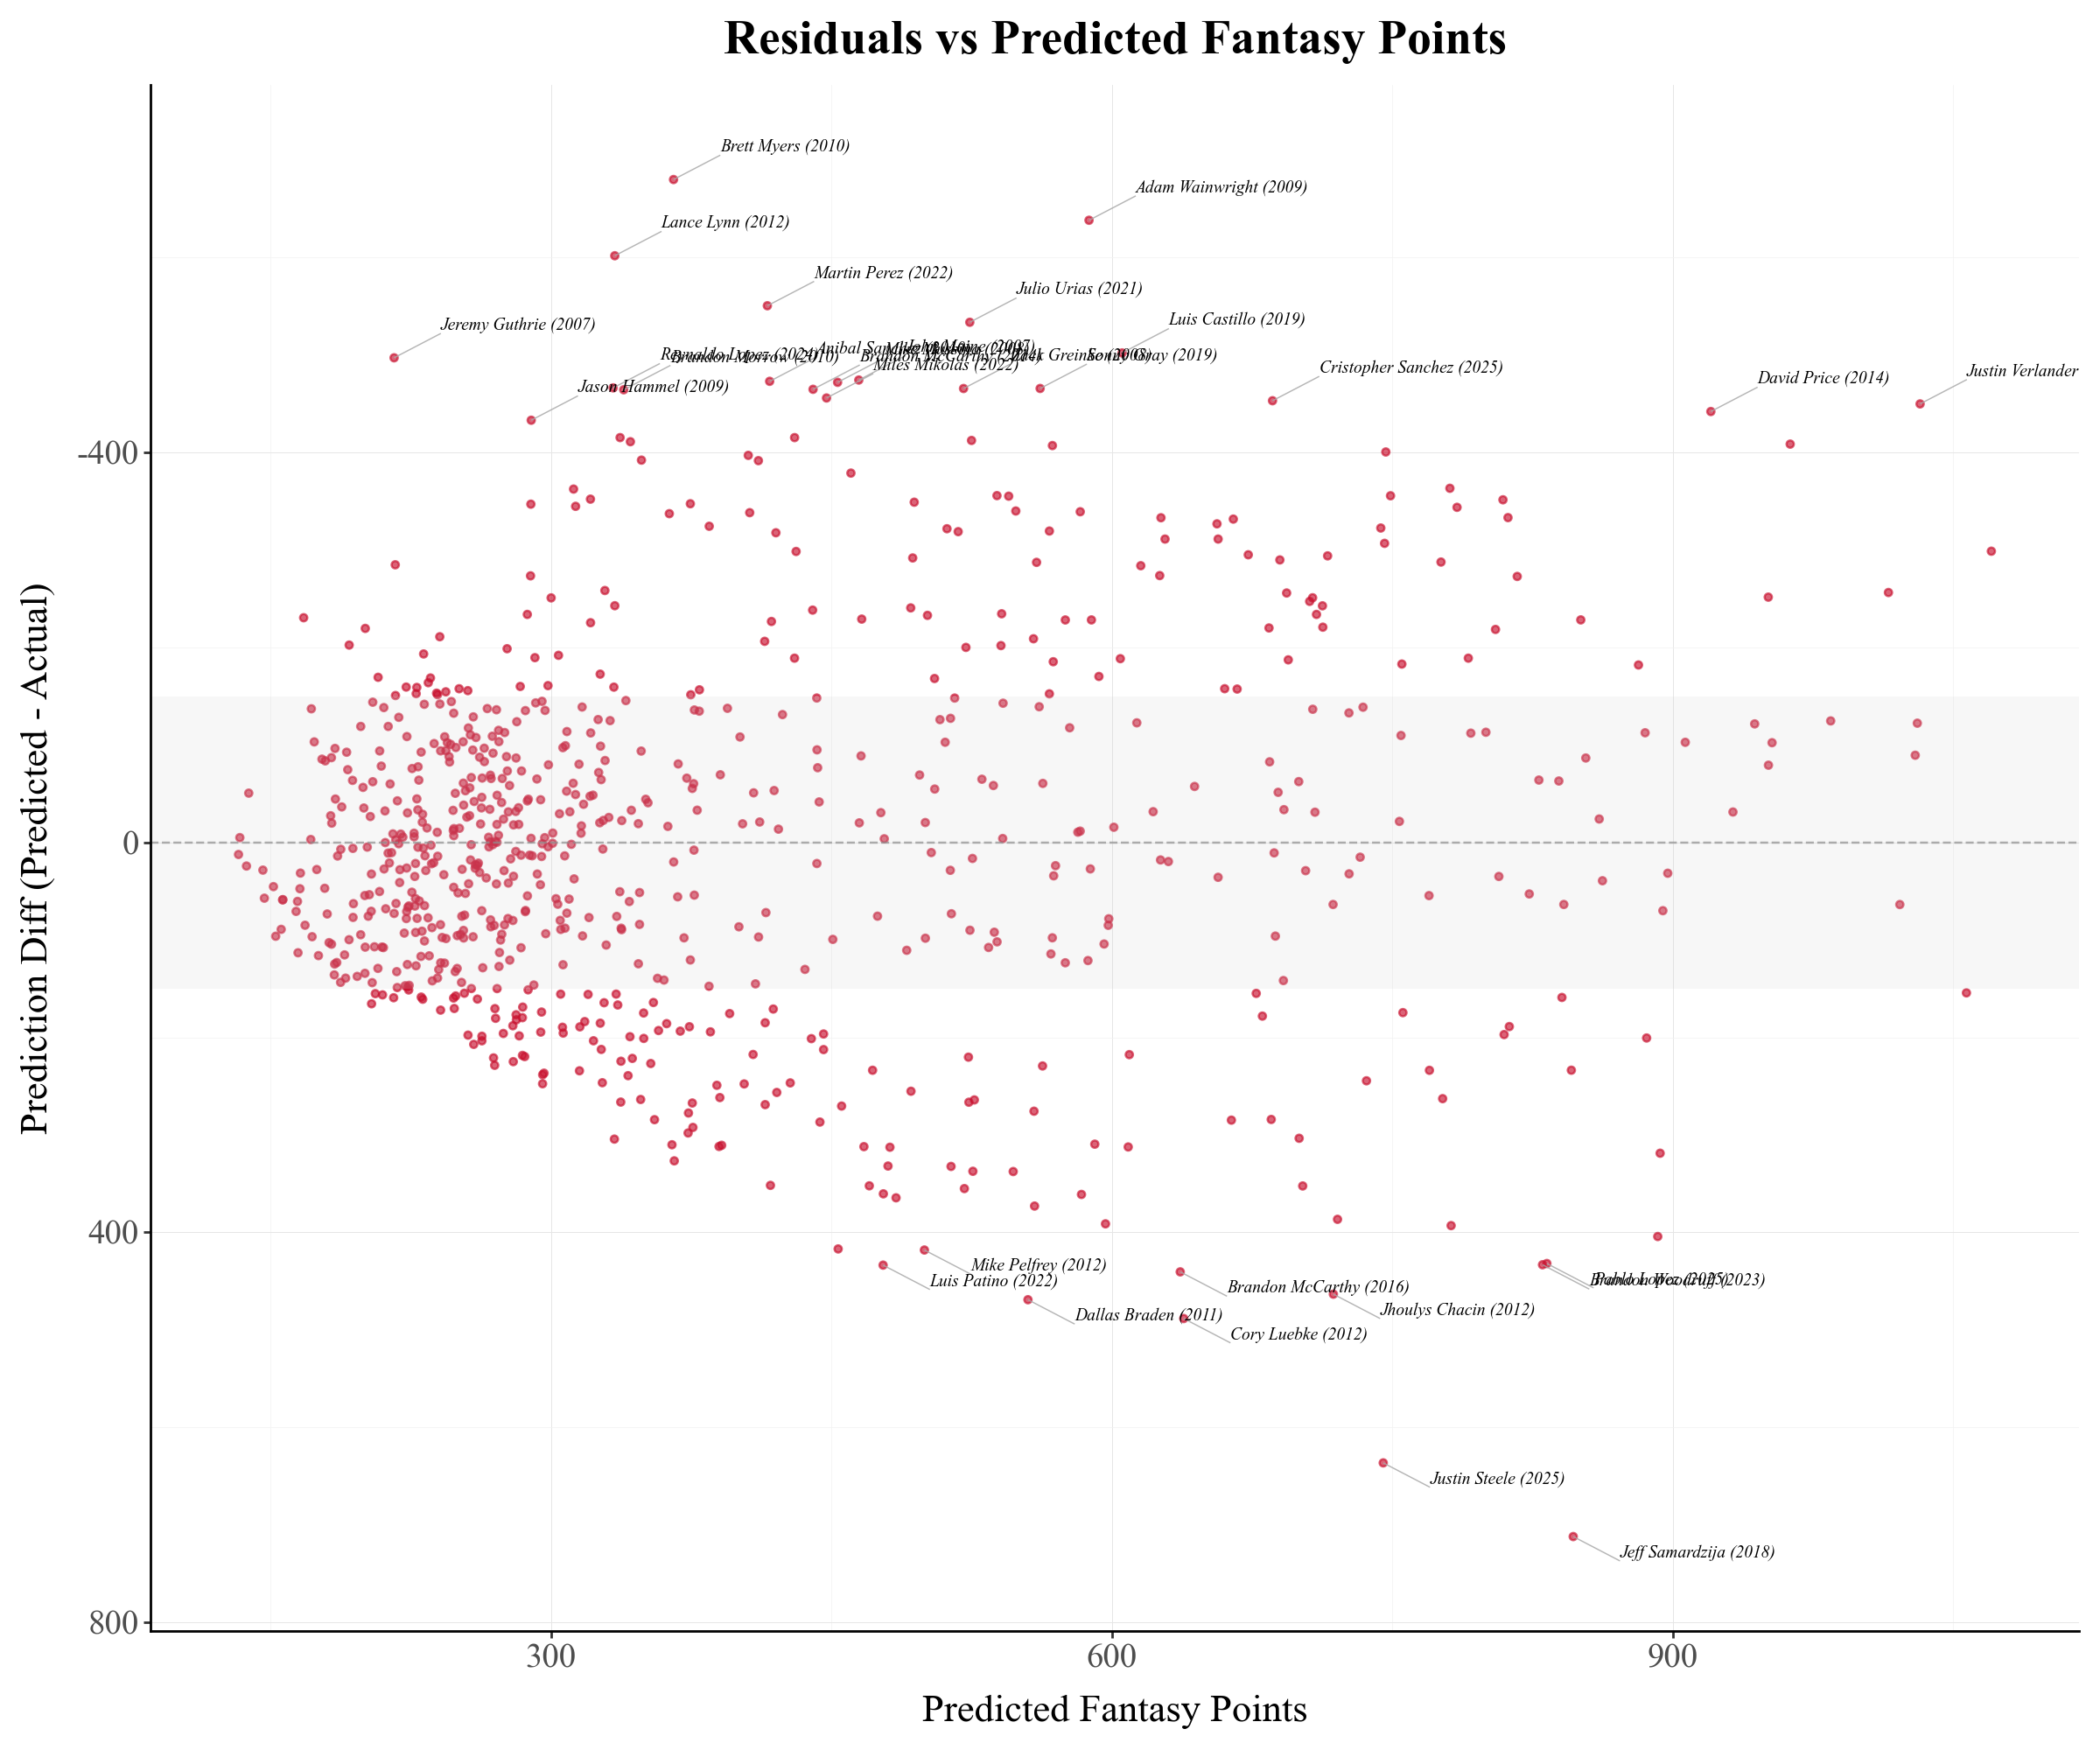

In [36]:
p2 = plot_resid_vs_pred_mlb(
    pitching_results,
    band=150,
    top_n=30,
    reverse_y=True,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p2.show()

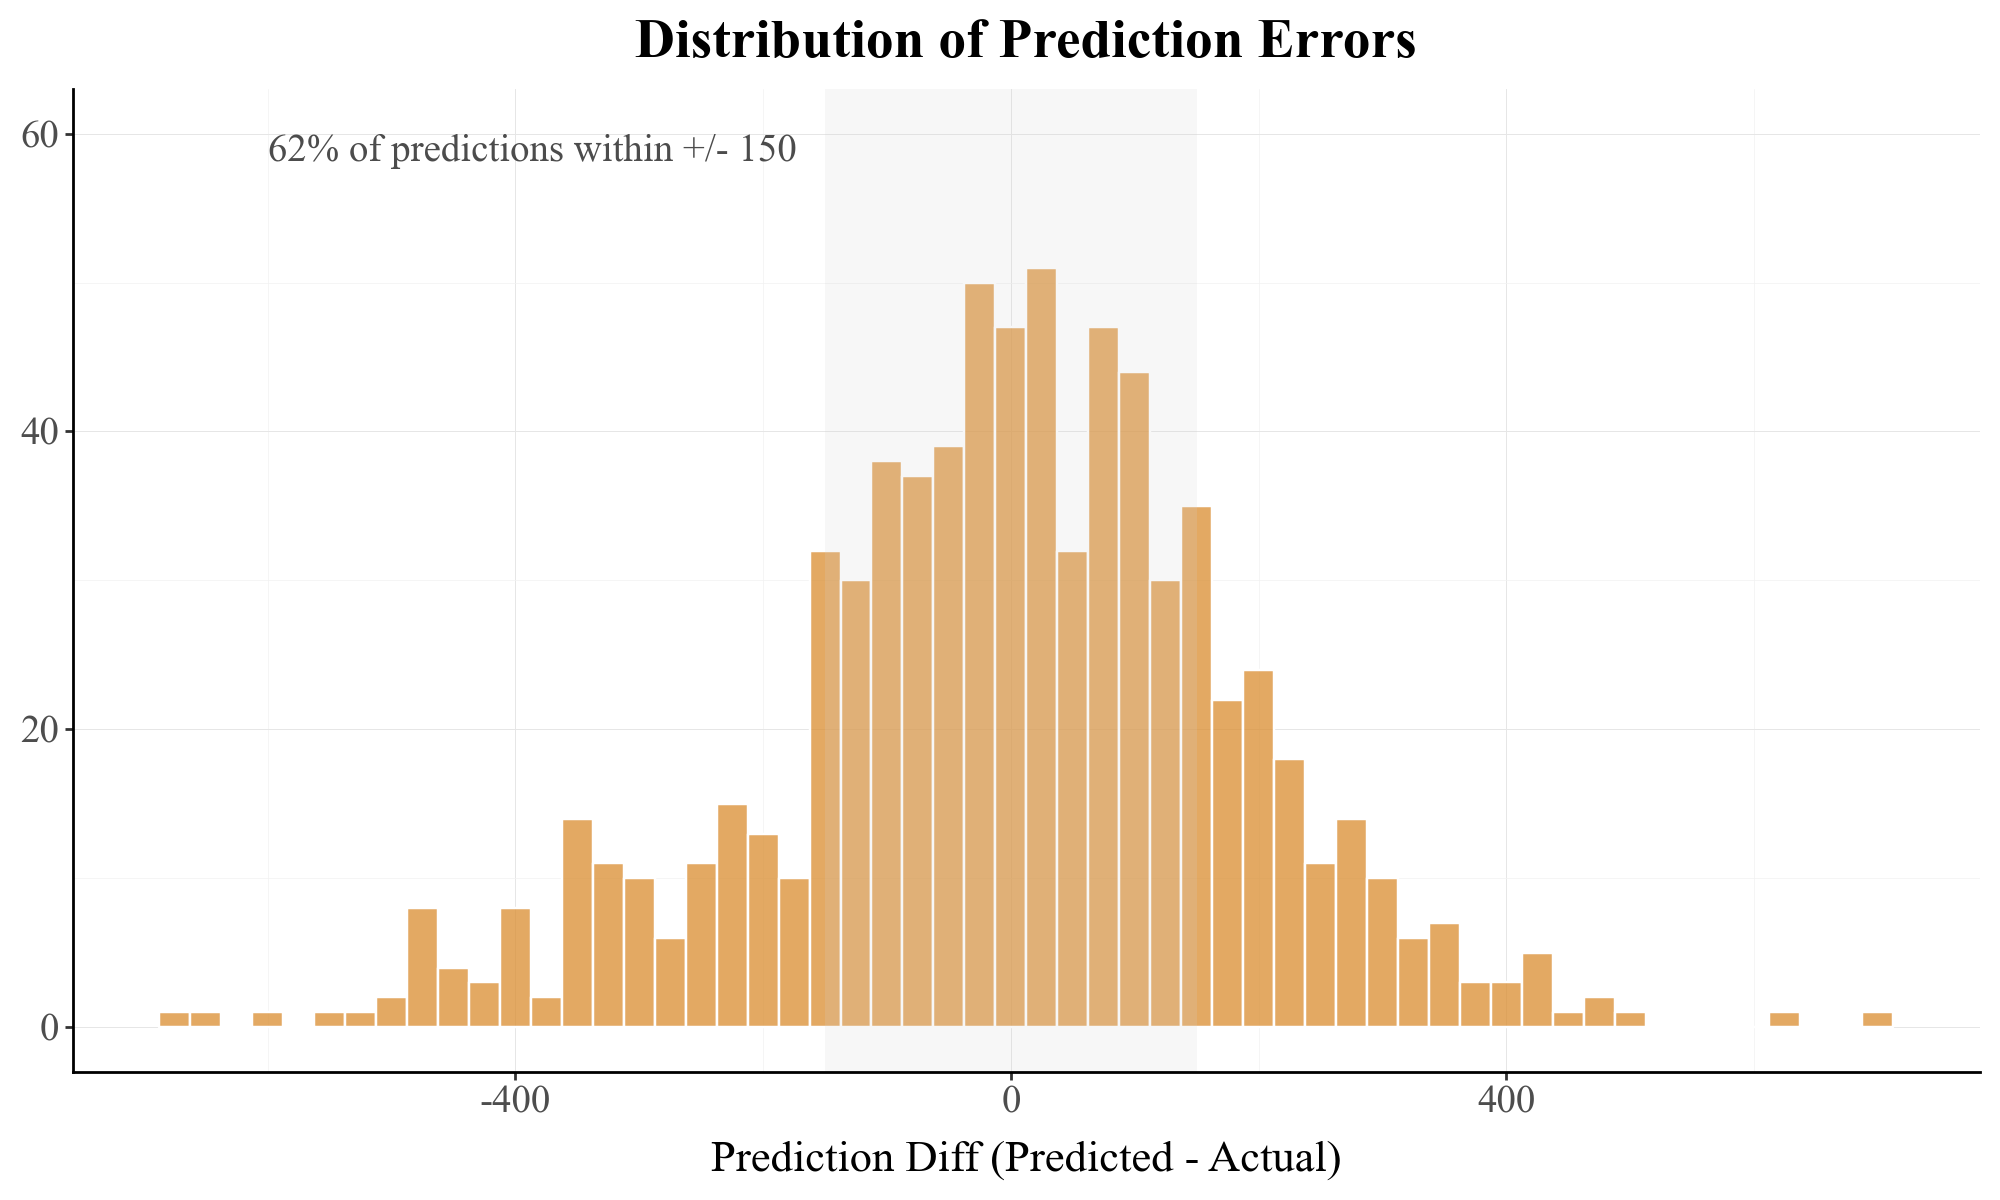

In [37]:
p3 = plot_resid_hist_mlb(
    pitching_results,
    band=150,
    binwidth=25,
    x_annotate=-600,    # custom annotation position
    y_annotate=60,      # custom annotation position
)
p3.show()

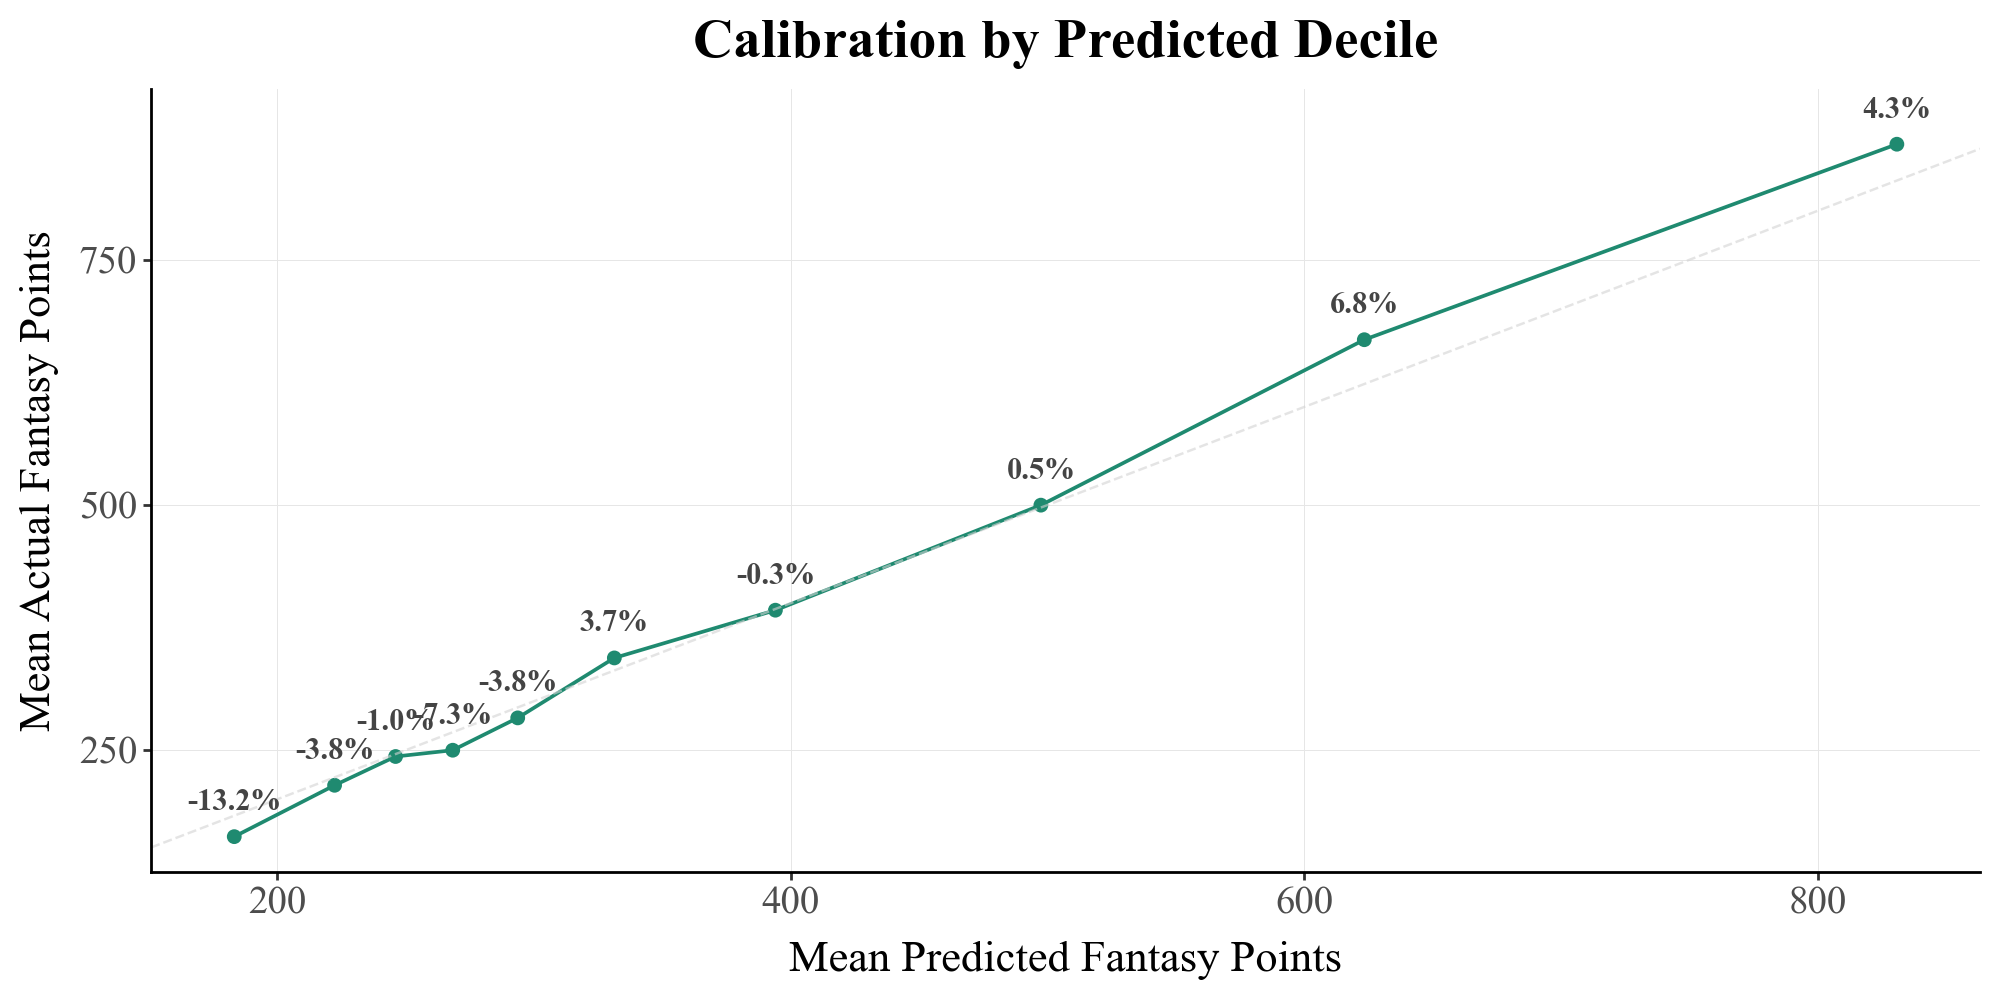

In [38]:
p4 = plot_decile_calib(pitching_results)
p4.show()

# Predicting Upcoming Season Player Performance

In [39]:
# Dropping fantasy_points_future from prediction dataframes
batting_pred = batting_pred.drop(columns=['fantasy_points_future'])
pitching_pred = pitching_pred.drop(columns=['fantasy_points_future'])

# Making predictions for the upcoming season
batting_pred['fantasy_points_pred'] = batting_model.predict(batting_pred.drop(columns=['IDfg', 'Name']))
pitching_pred['fantasy_points_pred'] = pitching_model.predict(pitching_pred.drop(columns=['IDfg', 'Name']))

# Merge intervals onto pred dataframes
batting_pred = batting_pred.merge(
    batting_intervals[['IDfg', 'pred_mean', 'pred_p10', 'pred_p50', 'pred_p90', 'pred_upside', 'pred_downside', 'implied_upside', 'pred_width_80']],
    on='IDfg',
    how='left'
)

pitching_pred = pitching_pred.merge(
    pitching_intervals[['IDfg', 'pred_mean', 'pred_p10', 'pred_p50', 'pred_p90', 'pred_upside', 'pred_downside', 'implied_upside', 'pred_width_80']],
    on='IDfg',
    how='left'
)

batting_pred.sort_values(by='fantasy_points_pred', ascending=False, inplace=True)
pitching_pred.sort_values(by='fantasy_points_pred', ascending=False, inplace=True)

In [40]:
display(batting_pred.head(5))

,IDfg,Season,Name,Age,G,AB,H,1B,2B,3B,...,player_tier_recent,fantasy_points_pred,pred_mean,pred_p10,pred_p50,pred_p90,pred_upside,pred_downside,implied_upside,pred_width_80
203,19755,2025,Shohei Ohtani,30,158,611,172,83,25,9,...,star,1646.477417,1386.598798,1006.342304,1418.913992,1743.269017,356.670219,380.256494,0.874216,736.926712
228,20123,2025,Juan Soto,26,160,577,152,88,20,1,...,star,1591.337891,1398.310135,1033.003879,1343.774948,1875.790450,477.480315,365.306255,1.214121,842.786570
92,15640,2025,Aaron Judge,33,152,541,179,94,30,2,...,star,1545.672241,1357.454623,909.733188,1375.225295,1812.833113,455.378490,447.721435,0.958953,903.099924
59,13510,2025,Jose Ramirez,32,158,593,168,101,34,3,...,star,1544.062256,1412.449243,1092.125394,1385.536699,1685.844961,273.395717,320.323849,0.784329,593.719566
373,25878,2025,Corbin Carroll,24,143,564,146,66,32,17,...,star,1529.934448,1443.274467,1002.974456,1477.075368,1838.259666,394.985199,440.300011,0.841889,835.285210


In [41]:
display(pitching_pred.head(5))

,IDfg,Season,Name,Age,G,GS,Pitches,Strikes,W,WAR,...,is_reliever,fantasy_points_pred,pred_mean,pred_p10,pred_p50,pred_p90,pred_upside,pred_downside,implied_upside,pred_width_80
186,17995,2025,Logan Webb,28,34,34,3282,2165,15,5.5,...,0,1062.251465,1042.705529,861.223528,1060.612863,1213.605566,170.900037,181.482001,0.844634,352.382038
279,20778,2025,Cristopher Sanchez,28,32,32,2897,1941,13,6.4,...,0,903.405151,960.671592,683.126232,944.145198,1260.064069,299.392477,277.545360,1.008875,576.937837
335,22267,2025,Tarik Skubal,28,31,31,2849,2003,13,6.6,...,0,901.571533,924.001803,672.499518,921.953943,1141.034962,217.033159,251.502285,0.803879,468.535444
24,10310,2025,Zack Wheeler,35,24,24,2394,1549,10,4.0,...,0,897.807007,852.983808,652.237207,838.051496,1052.024871,199.041062,200.746601,0.913844,399.787664
248,19959,2025,Jesus Luzardo,27,32,32,3015,1955,15,5.3,...,0,884.296570,850.758699,631.862100,870.043857,1048.965175,198.206476,218.896599,0.840172,417.103075


In [42]:
# Splitting names into first and last
batting_pred = split_name(batting_pred, 'Name')
pitching_pred = split_name(pitching_pred, 'Name')

# Creating combined batting dataframe
batting_final = combine_projections(batting_pred, batting_projections)

Duplicate rows found:


,IDfg,Season,Name,Age,G,AB,H,1B,2B,3B,...,pred_p90,pred_upside,pred_downside,implied_upside,pred_width_80,first_name,last_name,Team,Positions,projected_fantasy_points
511,13301.0,2025.0,Max Muncy,34.0,100.0,313.0,76.0,45.0,10.0,2.0,...,1164.718948,321.522562,311.599405,0.978869,633.121967,max,muncy,LAD,3B,896.0
512,13301.0,2025.0,Max Muncy,34.0,100.0,313.0,76.0,45.0,10.0,2.0,...,1164.718948,321.522562,311.599405,0.978869,633.121967,max,muncy,ATH,"2B,3B,SS",659.0
513,29779.0,2025.0,Max Muncy,22.0,63.0,206.0,44.0,28.0,7.0,0.0,...,933.772718,387.388043,370.524893,1.015560,757.912936,max,muncy,LAD,3B,896.0
514,29779.0,2025.0,Max Muncy,22.0,63.0,206.0,44.0,28.0,7.0,0.0,...,933.772718,387.388043,370.524893,1.015560,757.912936,max,muncy,ATH,"2B,3B,SS",659.0


In [43]:
# Filter the batting_final DataFrame to drop rows where Name is "Max Muncy" and projected_fantasy_points < 750
batting_final = batting_final[~((batting_final['Name'] == 'Max Muncy') & (batting_final['projected_fantasy_points'] < 750))]

In [44]:
# Creating combined pitching dataframe
pitching_final = combine_projections(pitching_pred, pitching_projections)

Duplicate rows found:


,IDfg,Season,Name,Age,G,GS,Pitches,Strikes,W,WAR,...,pred_p90,pred_upside,pred_downside,implied_upside,pred_width_80,first_name,last_name,Team,Positions,projected_fantasy_points
609,6984.0,2025.0,Luis Garcia,38.0,58.0,0.0,896.0,572.0,2.0,0.7,...,389.739059,194.529565,158.052756,1.201119,352.582321,luis,garcia,NYM,RP,261.9
610,6984.0,2025.0,Luis Garcia,38.0,58.0,0.0,896.0,572.0,2.0,0.7,...,389.739059,194.529565,158.052756,1.201119,352.582321,luis,garcia,NaN,SP,198.1


In [45]:
# # Filter the pitching_final DataFrame to drop rows where Name is Luis Garcia and position is not RP
pitching_final = pitching_final[~((pitching_final['Name'].isin(['Luis Garcia'])) & (pitching_final['Positions'] != 'RP'))]

# Finalizing Predictions & Creating Relative Positional Value Scores

In [46]:
# Suppress the SettingWithCopyWarning while updating player names
pd.options.mode.chained_assignment = None  # default='warn'

# Assigning position groups, cleaning player names, combining projections, and selecting final columns
batting_final = finalize_predictions(
    batting_final,
    mode="bat",
    position_overrides=BAT_POS_OVERRIDES,
)
pitching_final = finalize_predictions(
    pitching_final,
    mode="pit",
)

# Splitting the batters into infielders and outfielders
batting_final_if, batting_final_of = split_batters_if_of(batting_final)

# Creating final projected score, with a blended weight combining model and expert projections
# Creating initial player rankings based on final projection
# Filtering to player pool based on position
batting_final_if = (
    batting_final_if
    .pipe(
        create_draft_pool,
        model_weight=MODEL_WEIGHT,
        projection_weight=PROJECTION_WEIGHT,
        rank_cutoff=batter_pool_if,
    )
)

batting_final_of = (
    batting_final_of
    .pipe(
        create_draft_pool,
        model_weight=MODEL_WEIGHT,
        projection_weight=PROJECTION_WEIGHT,
        rank_cutoff=batter_pool_of,
    )
)

pitching_final = (
    pitching_final
    .pipe(
        create_draft_pool,
        model_weight=MODEL_WEIGHT,
        projection_weight=PROJECTION_WEIGHT,
        rank_cutoff=pitcher_pool,
    )
)

batting_final = pd.concat([batting_final_if, batting_final_of])

# Assigning player position groups
batting_final = assign_position_group(batting_final, position_col = 'Position')
pitching_final = assign_position_group(pitching_final, position_col = 'Position')

# Combine dataframes into a complete dataframe containing batters and hitters
combined_df = pd.concat([batting_final, pitching_final])

# Setting missing values in the implied_upside column to 1
combined_df['implied_upside'] = combined_df['implied_upside'].fillna(1)

In [53]:
# Calculating relative positional values & ranking players within position based on projected value
value_df = calculate_relative_value(
    df=combined_df,
    position_col="position_group",
    projection_col="final_projection",
    vorp_cutoff=0.67,
    vorp_scale=1, # VORP scale set to 1, see validation within "estimate_vorp_scale.ipynb"
    dampening_map=POS_DAMPENING_MAP,
)

# Saving value_df to CSV for vorp_scale estimation
# value_df.to_csv('notebooks/value_df.csv', index=False)

# Create Player Value Segments

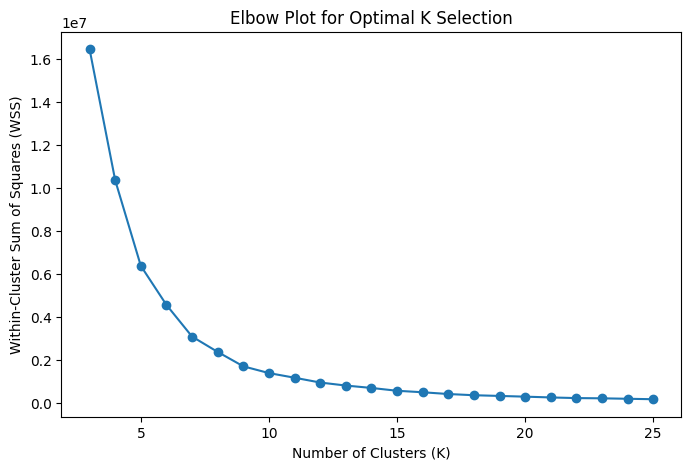

In [54]:
# Evaluating clustering performance on varying K values
determine_optimal_k(value_df, max_k = 25)

In [55]:
# Setting a K value and placing players into relative value tiers
final_df = segment_players(value_df, k = 20)

In [56]:
# Sorting final dataframe based on relative value, player value tier & position rank
final_df = final_df.sort_values(by = ['relative_value', 'player_value_tier', 'position_rank'], ascending = False)

# Selecting final columns for output
final_df = final_df[['Name', 'Age', 'Team', 'Position', 'position_group', 'fantasy_points_pred', 'projected_fantasy_points', 
                     'final_projection', 'pred_downside', 'pred_upside', 'implied_upside', 'relative_value',  
                     'overall_ranking', 'position_rank', 'player_value_tier']]

In [57]:
# Saving out final dataframe
final_df.to_csv(f'data/predictions_{datetime.now().strftime('%Y-%m-%d')}_{FORMAT}.csv', index=False)